<a href="https://colab.research.google.com/github/Uniholder/Specialization-Yandex-MIPT/blob/main/6_Final_projects/2_churn_prediction/week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
!mkdir data
!wget -O data/orange_small_churn_data.train https://stepik.org/media/attachments/lesson/90608/_847b6cd041836e8fa914243e83d898fb_orange_small_churn_data.train
!wget -O data/orange_small_churn_labels.train https://stepik.org/media/attachments/lesson/90608/_ce5e9e4280a8856218f1886f007de2a4_orange_small_churn_labels.train
!gdown -O data/ 1rW8ZBa870U3DHzERRfy1q777914JKPtA

--2022-08-19 10:16:55--  https://stepik.org/media/attachments/lesson/90608/_847b6cd041836e8fa914243e83d898fb_orange_small_churn_data.train
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23722578 (23M) [application/octet-stream]
Saving to: ‘data/orange_small_churn_data.train’

data/orange_small_c 100%[===================>]  22.62M  13.4MB/s    in 1.7s    

2022-08-19 10:16:57 (13.4 MB/s) - ‘data/orange_small_churn_data.train’ saved [23722578/23722578]

--2022-08-19 10:16:57--  https://stepik.org/media/attachments/lesson/90608/_ce5e9e4280a8856218f1886f007de2a4_orange_small_churn_labels.train
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117024 (114K) [application/octet-stream]
Saving to: ‘data/orange_small_churn_labels.train’

data/ora

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline as SklPipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, cv, Pool

PATH_TO_DATA = 'data'
# PATH_TO_DATA = '../input/churn-prediction-spec'

# Данные

In [4]:
df_raw = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
labels = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None, squeeze=True)
df_raw.shape

(40000, 230)

In [5]:
num_vars = df_raw.columns[:190]
cat_vars = df_raw.columns[190:]
na_vars = df_raw.columns[df_raw.isna().all()]

nna_num_vars = list(set(num_vars) - set(na_vars))
nna_cat_vars = list(set(cat_vars) - set(na_vars))

In [6]:
df_raw['target'] = labels
df = df_raw.dropna(axis=1, how='all')
df.shape

(40000, 213)

In [7]:
df_train, df_ho = train_test_split(df, test_size=5000)
df_train.shape, df_ho.shape

((35000, 213), (5000, 213))

## Baseline

In [8]:
cols = df_train.drop('target', axis=1).columns

In [9]:
si = SimpleImputer(strategy='most_frequent')
X_imp = pd.DataFrame(si.fit_transform(df_train[cols]), columns=cols)
X_val_imp = pd.DataFrame(si.transform(df_ho[cols]), columns=cols)

In [10]:
y = df_train.target
y_val = df_ho.target

In [11]:
base_params = {
    'eval_metric': 'AUC:hints=skip_train~false', 
    'verbose': False,
    'loss_function': 'Logloss'
}

In [12]:
%%time
model = CatBoostClassifier(**base_params, cat_features=nna_cat_vars)
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7346440720878449
CPU times: user 8min 41s, sys: 26.3 s, total: 9min 8s
Wall time: 4min 53s


In [13]:
%%time
cv_results = cv(
    params={**base_params},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    # plot=True,
    type='Classical'
)

Training on fold [0/5]

bestTest = 0.7419467207
bestIteration = 977

Training on fold [1/5]

bestTest = 0.7355747105
bestIteration = 469

Training on fold [2/5]

bestTest = 0.7510915961
bestIteration = 442

Training on fold [3/5]

bestTest = 0.7510417063
bestIteration = 522

Training on fold [4/5]

bestTest = 0.7355888803
bestIteration = 695

CPU times: user 38min 18s, sys: 2min 57s, total: 41min 16s
Wall time: 21min 36s


In [18]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.508447,0.013342,0.512898,0.018675,0.661708,0.000069,0.661700,0.000075
1,1,0.543066,0.044849,0.542748,0.044818,0.632111,0.000844,0.632068,0.000893
2,2,0.583562,0.043775,0.585365,0.038866,0.604440,0.000886,0.604398,0.000949
3,3,0.588719,0.043111,0.590594,0.038647,0.579468,0.000836,0.579432,0.000907
4,4,0.597498,0.034074,0.598425,0.030738,0.556364,0.000711,0.556318,0.000790
...,...,...,...,...,...,...,...,...,...
995,995,0.741394,0.007948,0.839974,0.002004,0.236810,0.002158,0.207633,0.001249
996,996,0.741406,0.007932,0.840006,0.002026,0.236805,0.002152,0.207619,0.001257
997,997,0.741476,0.007886,0.840172,0.002051,0.236789,0.002133,0.207569,0.001277
998,998,0.741468,0.007894,0.840286,0.001989,0.236792,0.002133,0.207529,0.001260


In [20]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(635, 0.7422765833272078)

# Инструкции

## 1. Learning curve

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [14]:
from sklearn.model_selection import  learning_curve

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)
import seaborn as sns
sns.set()

In [15]:
cv_scheme = StratifiedShuffleSplit(random_state=0)

In [21]:
%%time
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
    estimator=model, # catboost
    X=X_imp,
    y=y,
    cv=cv_scheme,
    scoring='roc_auc',
    n_jobs=-1,
    return_times=True,
    verbose=10
)

[learning_curve] Training set sizes: [ 3150 10237 17325 24412 31500]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  7.2min remaining: 112.6min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 23.2min remaining: 105.7min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 38.8min remaining: 90.5min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 54.6min remaining: 75.4min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 68.9min remaining: 58.7min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 86.3min remaining: 44.5min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 102.6min remaining: 28.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 117.9min remaining: 13.1min


CPU times: user 1min 14s, sys: 7.33 s, total: 1min 22s
Wall time: 2h 12min 12s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 132.2min finished


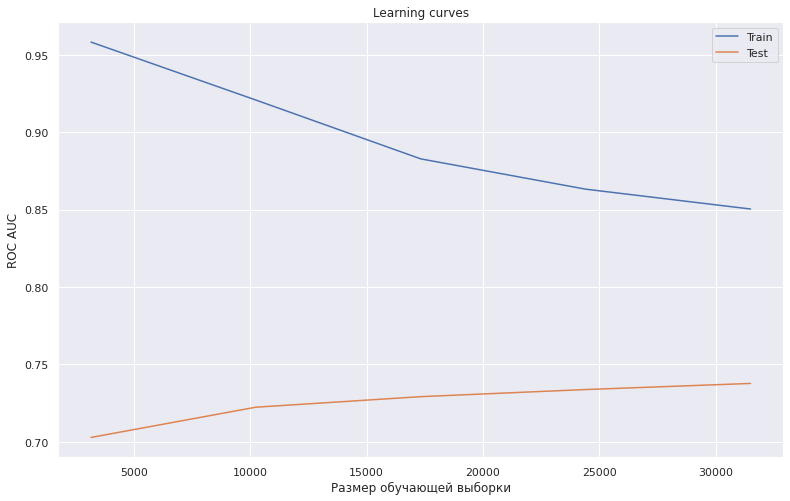

In [22]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC AUC')
plt.title('Learning curves');

## 2. Balancing

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

### 2.1 Веса

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

For imbalanced datasets with binary classification the weight multiplier can be set to 1 for class 0 and to $\left(\frac{sum\_negative}{sum\_positive}\right)$ for class 1.

In [ ]:
print(y.value_counts(), end='\n\n')
print('Соотношения классов:')
print(y.value_counts()[1] / y.value_counts()[-1])
print(y.value_counts()[-1] / y.value_counts()[1])

-1    32378
 1     2622
Name: 0, dtype: int64

Соотношения классов:
0.08098091296559393
12.348588863463005


Тестируем параметры, отвечающие за "взвешивание"

In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
#     auto_class_weights='SqrtBalanced',  # автобалансировка
#     scale_pos_weight=0.01,
    class_weights={-1: 1, 1: 0.1}
)

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7241630136016324
CPU times: user 22.7 s, sys: 3.33 s, total: 26 s
Wall time: 3.42 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.73081423 0.71458127 0.72205602 0.72739209 0.71932116 0.73284645
 0.7091553  0.75142155] 
 0.7259485094850948
CPU times: user 1.2 s, sys: 60.4 ms, total: 1.26 s
Wall time: 28.1 s


|parameter|hold out ROC AUC|cv ROC AUC|
|-|-|-|
|no weighting|0.7289309070921831|0.7193227253652948|
|auto_class_weights='Balanced'|0.702416999253352|0.6993457051049323|
|auto_class_weights='SqrtBalanced'|0.7222268837053196|0.7017379791031124|
|scale_pos_weight=12|0.7103826631742025|0.6945638092970404|
|scale_pos_weight=100|0.7147068981032223|0.7031370085200082|
|scale_pos_weight=1000|0.6904806637627653|0.687114106577899|
|scale_pos_weight=0.5|0.7362143730953788|0.7278346295658897|
|scale_pos_weight=0.08|0.7307963110238805|0.7261320719132063|
|scale_pos_weight=0.01|0.7226719540045382|0.7014117599215424|

Вывод: получили эффект, обратный предполагаемому. Наилучшее качество получено при уменьшении веса меньшего класса `class_weights={-1: 1, 1: 0.1}`

### 2.2 Undersampling

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
THRESH = 70

df_train_n_churn = df_train[y_train == -1]
df_train_undersampling = pd.concat([df_train_n_churn.dropna(thresh=THRESH), df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling.shape

(21200, 212)

In [ ]:
%%time
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train_undersampling.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179
)
model.fit(X_train_undersampling, y_train[df_train_undersampling.index])
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6823283266253334
CPU times: user 8.86 s, sys: 280 ms, total: 9.14 s
Wall time: 5.04 s


Используем библиотеку imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler  # 0.22.2.post1 sklearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import random
random.seed(2179)

In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
)

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
class UnderSampler(BaseEstimator, TransformerMixin):
    '''
    Класс задумывался для использования в пайплайне, как последний шаг препроцессинга. 
    Реализация такого пайпа кривая
    '''
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        self.positive_class = X[X.target == 1].index.to_list()
        self.negative_class = X[X.target == -1].index.to_list()
        return self

    def transform(self, X, y=None):
        negative_undersampled = random.sample(self.negative_class, len(self.positive_class))
        return pd.concat([X.loc[negative_undersampled], X.loc[self.positive_class]])

#### Random undersampling

In [ ]:
rus = RandomUnderSampler(1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
df_train_rus, y_train_rus = rus.fit_resample(df_train, y_train)
y_train_rus.value_counts()

-1    2595
 1    2595
Name: 0, dtype: int64

In [ ]:
%%time
model.fit(X_train_rus, y_train_rus)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6799104918120351
CPU times: user 2.42 s, sys: 61.6 ms, total: 2.49 s
Wall time: 1.33 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_rus, 
                         y=y_train_rus, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.71459756 0.70369765 0.69965845 0.71480546 0.69459459 0.66952777
 0.71244431 0.67882388] 
 0.698518711018711
CPU times: user 331 ms, sys: 30.3 ms, total: 362 ms
Wall time: 14.7 s


0.720316436934934 - 0.5

0.7273611523611523 - 1

0.7260967837557433 - 0.25

#### CondensedNearestNeighbour

In [ ]:
%%time
from imblearn.under_sampling import CondensedNearestNeighbour

cnb = CondensedNearestNeighbour(n_jobs=-1, n_neighbors=1)
X_train_cnb, y_train_cnb = cnb.fit_resample(X_train, y_train)
y_train_cnb.value_counts()

KeyboardInterrupt: ignored

#### NearMiss

In [ ]:
numeric_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler())
])

categorical_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = SklPipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))  # необходимо для выбора категориальных колонок (CatBoost)
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)

In [ ]:
%%time
from imblearn.under_sampling import NearMiss

nm = NearMiss(n_jobs=-1, version=3, n_neighbors=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)
y_train_nm.value_counts()

CPU times: user 3.76 s, sys: 268 ms, total: 4.03 s
Wall time: 2.74 s


In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    logging_level='Silent',
    random_seed=2179,
)

# model = LogisticRegression(
#     solver='liblinear',
#     random_state=2179
# )

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train_nm, y_train_nm)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6543507673145099
CPU times: user 2.55 s, sys: 59.3 ms, total: 2.61 s
Wall time: 1.4 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_rus, 
                         y=y_train_rus, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

KeyboardInterrupt: ignored

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6804344033743996
CPU times: user 6.14 s, sys: 175 ms, total: 6.32 s
Wall time: 3.35 s


In [ ]:
import random

df_train_n_churn = df_train[y_train == -1]
df_train_n_churn.shape

(32387, 212)

In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
    scale_pos_weight=0.5
)

In [ ]:
# THRESH = 75

# df_train_undersampling = pd.concat([df_train_n_churn.dropna(thresh=THRESH), df_train[y_train == 1]])

# X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
# X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

#########################

SIZE = 10000

random.seed(2179)
sample = random.sample(df_train_n_churn.index.to_list(), SIZE)

df_train_undersampling = pd.concat([df_train_n_churn.loc[sample], df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

In [ ]:
%%time
model.fit(X_train_undersampling, y_train[df_train_undersampling.index])
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7382670590073496
CPU times: user 14.5 s, sys: 2.45 s, total: 16.9 s
Wall time: 2.23 s


|threshold|ho ROC AUC|
|-|-|
|70|0.6918684957679605|
|73|0.632738762534673|
|75|0.5903060839540146|

|size|ho ROC AUC|
|-|-|
|32387|0.7411591160096268|
|30000|0.728222091917271|
|25000|0.7424411741466262|
|20000|0.7436370884329007|
|15000|0.7333265606443797|
|10000|0.7382670590073496|

#### Oversampling

In [ ]:
ros = RandomOverSampler()

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

y_train_ros.value_counts()

-1    32405
 1    32405
Name: 0, dtype: int64

In [ ]:
%%time
model.fit(X_train_ros, y_train_ros)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6459676140828792
CPU times: user 29.2 s, sys: 466 ms, total: 29.7 s
Wall time: 15.9 s


In [ ]:
ros = RandomOverSampler()

df_train_ros, y_train_ros = ros.fit_resample(df_train, y_train)

y_train_ros.value_counts()

-1    32405
 1    32405
Name: 0, dtype: int64

In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_ros, 
                         y=y_train_ros, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.99071255 0.98906849 0.99043019 0.99209663 0.98964169 0.99224043
 0.99017383 0.99064513] 
 0.9906261189581025
CPU times: user 3.17 s, sys: 312 ms, total: 3.48 s
Wall time: 2min 15s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_ros, 
                         y=y_train_ros, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.99128679 0.99006127 0.99196598 0.98970244 0.98934219 0.98863148
 0.99297809 0.9907834 ] 
 0.9905939548645633
CPU times: user 1.91 s, sys: 1.31 s, total: 3.22 s
Wall time: 44.4 s


## 3. Признаки

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [ ]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

Стратегия 1: замена на самое частое значение

In [ ]:
numeric_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('ordinal_encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = SklPipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler())
    ('to_dataframe', DataFramer(df.columns))
])

In [ ]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)

CPU times: user 725 ms, sys: 130 ms, total: 856 ms
Wall time: 860 ms


In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179
)

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7160535708096025
CPU times: user 16.8 s, sys: 769 ms, total: 17.6 s
Wall time: 9.48 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.71342679 0.74458048 0.74142213 0.75395244 0.71328466 0.72533502
 0.74212878 0.7277212 ] 
 0.7327314367226978
CPU times: user 1.63 s, sys: 237 ms, total: 1.87 s
Wall time: 1min 19s


|method num|method cat|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|most_frequent|most_frequent|0.7413546342506111|0.7360205959164293|
|mean|most_frequent|0.727643098112471|0.7459786028015195|
|median|most_frequent|0.7243560701108726|0.7375290835707502|

## 4. Categorical encoding

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        dict_ = {}
        self.cat_cols = X.select_dtypes('object').columns
        for col in self.cat_cols:
            dict_[col] = X.groupby(col).size() / len(X)
        self.fe = dict_
        return self

    def transform(self, X, y=None):
        X[self.cat_cols] = X[self.cat_cols].apply(lambda col: col.map(self.fe[col.name]))
        return X

In [ ]:
%%time
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
#     ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('to_dataframe', DataFramer(df.columns)),
    ('frequency_encoder', FrequencyEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
#     ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)
X_train

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'r__I'

In [ ]:
preprocessor_pipeline['preprocessor'].transformers_[1][1][2].cat_cols

AttributeError: 'FrequencyEncoder' object has no attribute 'cat_cols'

In [ ]:
dict_ = {}
for col in tmp.columns:
    dict_[col] = tmp.groupby(col).size() / len(tmp)

In [ ]:
dict_

{'Var191': Var191
 r__I    1.0
 dtype: float64,
 'Var192': Var192
 0G9vyxdMWg    0.000029
 0kQTmBU3gb    0.000029
 0kQqrQsiZt    0.000029
 0vimfo8zhV    0.006743
 1GdOj17ejg    0.005771
                 ...   
 zKnr4RXktW    0.007257
 zKnrjIPxRp    0.000029
 zcROj17IEC    0.006000
 zcROj1KVEH    0.001543
 zcRZptzip9    0.004829
 Length: 346, dtype: float64,
 'Var193': Var193
 2Knk1KF                                     0.145314
 2wnefc9ISdLjfQoAYBI                         0.000114
 5QKIjwyXr4MCZTEp7uAkS8PtBLcn                0.001286
 8kO9LslBGNXoLvWEuN6tPuN59TdYxfL9Sm6oU       0.000171
 9U2tunPAje3TwfLLUQxzM3dC1ghn                0.000057
 AERks4l                                     0.043943
 B2T7ZTgOX7xpBPBD28SLvVWgBkc13Sm0a3tk2       0.000029
 BrRu5UxtiQY9TTJ8ABKpfS                      0.000400
 ByQdnLRlFnny2k4AJzG                         0.001771
 DH86UFkz9LK6My0ezUgZx96oI                   0.000029
 Fveq5yuDUj6drSMiZO3mXe                      0.000429
 GpoBynXzkxADI7bZBtqvX2IPV5t

In [ ]:
tmp.apply(lambda col: col.map(dict_[col.name]))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [ ]:
tmp.apply(lambda col: tmp.groupby(col.name).size() / len(tmp))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
000J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00ARusu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AYONy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzfHvGh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfLM_S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfUfAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfo6HG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tmp.apply(lambda col: col.map(tmp.groupby(col.name).size() / len(tmp)))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [ ]:
# model = CatBoostClassifier(
#     max_depth=6, 
#     n_estimators=100, 
#     cat_features=df_train.select_dtypes(include='object').columns.to_list(),
#     logging_level='Silent',
#     one_hot_max_size=2
# )

model = LogisticRegression(random_state=2179)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6261950605679286
CPU times: user 25.3 s, sys: 371 ms, total: 25.7 s
Wall time: 3.32 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.64029016 0.62795218 0.64354941 0.63887095 0.62355544 0.60999628
 0.60809731 0.62896355] 
 0.627659408314434
CPU times: user 2.29 s, sys: 141 ms, total: 2.43 s
Wall time: 8.67 s


|model|method|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|CatBoostClassifier|one_hot_max_size=2|0.7495747310914603|0.7238648100650569|
|CatBoostClassifier|one_hot_max_size=100|0.7473075616276679|0.7253192386638854|
|LogisticRegression|OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)|0.6807580466653527|0.6522513838530051|
|LogisticRegression|OneHotEncoder(handle_unknown='ignore')|0.6261950605679286|0.627659408314434|

## 5. Отбор признаков

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

## 6. Подбор гиперпараметров

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

## 7. Важность признаков

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

# Тест

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_test_data.csv'), index_col=0)
df_test

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,2352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,225.0,NaN,0.0,56.0,NaN,NaN,388.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6726960.0,NaN,NaN,...,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,0Xwj,PHNvXy8,xUOdRmdN20,IBm9AvG,NaN,skcI,HLqf,vzJD,NaN,lVqb,NKv3VA1BpP,sBgB,NaN,uKAI,L84s,Ie_5MZs,NaN,xRz9wph,NaN,CWNY2py,jgOV,UYBR,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,NaN,NaN,1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,140.0,NaN,0.0,96.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,0Xwj,6KF0k8W,V4E_TU9097,NaN,NaN,CZsd,F3hy,vzJD,09_Q,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,TDcECyH,PDRj,cJvF,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,NaN,NaN,2824.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,215.0,NaN,4.0,16.0,NaN,NaN,324.48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2988486.0,NaN,NaN,...,NaN,75lTmBtFkL,RO12,SEuy,taul,1K8T,AnrR,ckoNVBU,_jTP8ioIlJ,JnrRQD4,smXZ,PwdO,9_Y1,C6Eu,VpdQ,sYC_,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,Iy8LM_S,NaN,kq0aHkC,laMb,UYBR,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,NaN,NaN,3732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.0,600.0,NaN,10.0,104.0,NaN,NaN,286.96,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6637740.0,NaN,NaN,...,NaN,YddTmBtueT,RO12,SEuy,taul,1K8T,487l,77f44U8,II0S8f9,a1lFLoc,smXZ,SOkz,9_Y1,C6Eu,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,GccbB3h,NaN,mAjbk_S,qLRt,UYBR,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,mCGq9ayE15,RO12,NaN,taul,1K8T,lK27,esxkA1P,767sa0XN9l,NaN,NaN,kVZt,9_Y1,vm5R,09_Q,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,eGzu,7Wwvby0,XqfQ,UYBR,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,714.0,7.0,NaN,NaN,NaN,NaN,NaN,2240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,150.0,NaN,10.0,80.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,m9SvyxLkBI,RO12,NaN,taul,1K8T,GYbZ,iJzviRg,3X0xOLn,jCrHwxI,NaN,CGbI,9_Y1,lXxA,09_Q,wMei,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,4kVnq_T26xq1p,NaN,xXRNJU2,NaN,uZLuDix,vawI,cJvF,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN
9996,NaN,NaN,NaN,NaN,NaN,812.0,7.0,NaN,NaN,NaN,NaN,NaN,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,0.0,104.0,NaN,NaN,253.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4147200.0,NaN,NaN,...,NaN,HYTrjIK12c,2Knk1KF,NaN,taul,1K8T,JLbT,BMnJ89M,5CtupK8,8DWmKv5,NaN,mK1t,9_Y1,7WNq,VpdQ,hAFG,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,Oc9VkgP,NaN,XTbPUYD,jQNd,cJvF,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,NaN,ELof,WqMG,RAYp,55YFVY9,mj86,NaN
9997,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,

In [ ]:
df_test.drop(nan_cols, axis=1, inplace=True)

In [ ]:
%%time
prediction = pipeline.predict_proba(df_test)
print(prediction)

[[9.37699177e-01 6.23008228e-02]
 [9.95547934e-01 4.45206595e-03]
 [9.98006901e-01 1.99309937e-03]
 ...
 [9.96141266e-01 3.85873397e-03]
 [9.96528196e-01 3.47180406e-03]
 [9.99058923e-01 9.41077330e-04]]
CPU times: user 412 ms, sys: 21.9 ms, total: 434 ms
Wall time: 422 ms


In [ ]:
write_to_submission_file(prediction[:, 1], 'result.csv')